# 语义歧义检测分析

本notebook专门针对用户故事中的**语义歧义**进行检测和分析。

## 语义歧义定义
语义歧义是指用户故事中的词语或短语存在多种含义解释，导致理解上的歧义。这种歧义通常源于：
- 词汇的多义性（polysemy）
- 句子结构的歧义性
- 上下文信息的缺失
- 领域专业术语的模糊使用

In [14]:
from ambiguity_detection_utils import AmbiguityDetector

# 创建语义歧义检测器
detector = AmbiguityDetector("semantic")

# 加载并准备数据
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=True)

print(f"测试数据集: {len(df_test)} 个用户故事")

Semantic歧义统计:
  有semantic歧义: 2831 (22.0%)
  无semantic歧义: 10016 (78.0%)
平衡测试集: 5662 个用户故事
  HasAmbiguity=True: 2831 (50.0%)
  HasAmbiguity=False: 2831 (50.0%)
测试数据集: 5662 个用户故事


In [15]:
# 使用参数化提示词生成器运行评估
sample_size = detector.get_recommended_sample_size()
print(f"推荐样本大小: {sample_size}")

results = detector.run_evaluation(
    df_test, 
    sample_size=sample_size,
    prompt_generator=detector.generate_prompt  # 使用通用提示词生成器
)

推荐样本大小: 50
=== Semantic歧义检测评估 ===
测试数据集: 5662 个用户故事
Processing model gpt-3.5-turbo...
API call failed (gpt-3.5-turbo): Connection error.
API call failed (gpt-3.5-turbo): Connection error.
  Processed 10/50 samples
API call failed (gpt-3.5-turbo): Connection error.
  Processed 20/50 samples
  Processed 30/50 samples
  Processed 40/50 samples
  Processed 50/50 samples
  Semantic Ambiguity Detection - Precision: 0.440, Recall: 1.000, F1: 0.611
Processing model deepseek-chat...
  Processed 10/50 samples
API call failed (deepseek-chat): Connection error.
API call failed (deepseek-chat): Connection error.
API call failed (deepseek-chat): Connection error.
  Processed 20/50 samples
API call failed (deepseek-chat): Connection error.
  Processed 30/50 samples
API call failed (deepseek-chat): Connection error.
  Processed 40/50 samples
  Processed 50/50 samples
  Semantic Ambiguity Detection - Precision: 0.440, Recall: 1.000, F1: 0.611


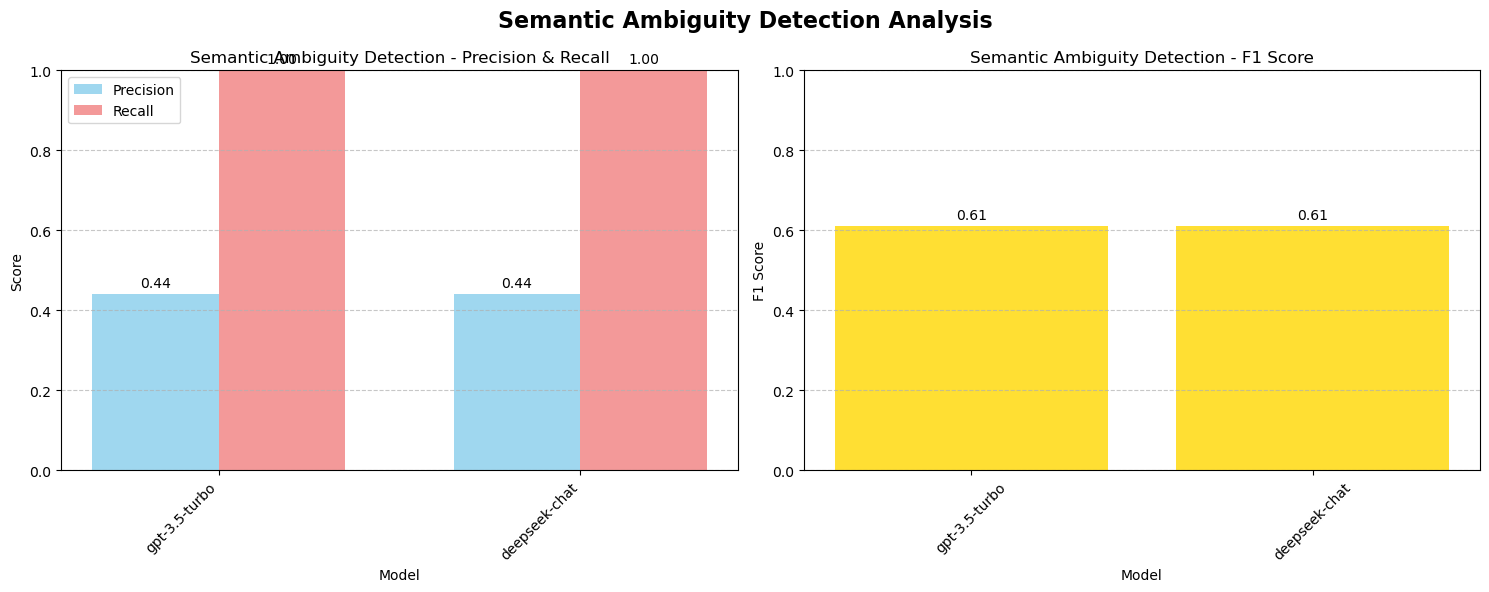

结果已保存到 semantic_ambiguity_evaluation_results.json

=== Semantic歧义检测评估总结 ===

Model: gpt-3.5-turbo
  Precision: 0.440
  Recall: 1.000
  F1 Score: 0.611

Model: deepseek-chat
  Precision: 0.440
  Recall: 1.000
  F1 Score: 0.611


In [16]:
# 创建可视化
detector.create_visualization(results, save_prefix="semantic")

# 保存结果
detector.save_results(results, "semantic_ambiguity_evaluation_results.json")

# 打印总结
detector.print_summary(results)

In [17]:
# 错误分析（可选）
from ambiguity_detection_utils import analyze_errors

analyze_errors(results, "semantic", num_examples=3)


=== Semantic歧义错误分析 ===

分析模型: gpt-3.5-turbo (F1: 0.611)

误报 (False Positives): 28 个
漏报 (False Negatives): 0 个

误报示例 (模型认为有歧义，实际无歧义):

1. 用户故事: As a seller, I would like to track order to find desired items with detailed specifications and comp...
   模型识别的歧义部分: unknown
   模型推理: parsing/api error...

2. 用户故事: As a store owner, I want to track order in order to find desired items with detailed specifications ...
   模型识别的歧义部分: unknown
   模型推理: parsing/api error...

3. 用户故事: As a patient, I need to access records so that I can ensure compliance with fast performance...
   模型识别的歧义部分: fast performance
   模型推理: The term 'fast performance' is vague and subjective, as it does not specify any specific metrics or criteria for what constitutes 'fast'. Different st...

漏报示例 (实际有歧义，模型未检测到):
